Cell 1 — Paths & basic checks

In [76]:
import sqlite3
import pandas as pd
from pathlib import Path

# Paths
DB_PATH = Path("data/UHCSDB/microstructures.sqlite")
IMG_DIR = Path("data/UHCSDB/micrographs")

print("DB exists:", DB_PATH.exists())
print("Images folder exists:", IMG_DIR.exists())


DB exists: True
Images folder exists: True


Cell 2 — Inspect DB tables (optional sanity)

In [77]:
conn = sqlite3.connect(DB_PATH)
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,user
1,collection
2,sample
3,micrograph


Cell 3 — Peek columns (optional sanity)

In [78]:
tables_list = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)['name'].tolist()
print("Tables:", tables_list)

for t in tables_list:
    try:
        df_ = pd.read_sql(f"SELECT * FROM '{t}' LIMIT 5;", conn)
        print(f"\n=== {t} ===")
        print(df_.columns.tolist())
        display(df_)
    except Exception as e:
        print(f"\n=== {t} === (could not preview) -> {e}")


Tables: ['user', 'collection', 'sample', 'micrograph']

=== user ===
['user_id', 'username', 'givenname', 'familyname', 'email', 'orcid']


,user_id,username,givenname,familyname,email,orcid
0,1,bdecost,Brian,DeCost,bdecost@andrew.cmu.edu,0000-0002-3459-5888
1,2,mhecht,Matthew,Hecht,mhecht@andrew.cmu.edu,None



=== collection ===
['collection_id', 'name', 'doi']


,collection_id,name,doi



=== sample ===
['sample_id', 'label', 'anneal_time', 'anneal_time_unit', 'anneal_temperature', 'anneal_temp_unit', 'cool_method']


,sample_id,label,anneal_time,anneal_time_unit,anneal_temperature,anneal_temp_unit,cool_method
0,1,3.1 IN1 Etched Sample 1,NaN,None,NaN,None,None
1,2,AC 800C 8H WQ,8.0,H,800.0,C,WQ
2,3,AC1 + vickers mark,NaN,None,NaN,None,None
3,4,AC1 1000C 5M WQ,5.0,M,1000.0,C,WQ
4,5,AC1 1100C 1H 650C 1H,1.0,H,1100.0,C,650-1H



=== micrograph ===
['micrograph_id', 'path', 'micron_bar', 'micron_bar_units', 'micron_bar_px', 'magnification', 'detector', 'sample_key', 'contributor_key', 'primary_microconstituent']


,micrograph_id,path,micron_bar,micron_bar_units,micron_bar_px,magnification,detector,sample_key,contributor_key,primary_microconstituent
0,1,micrograph1.tif,5.0,um,129,4910x,SE,42,2,pearlite
1,2,micrograph2.tif,10.0,um,103,1964X,SE,18,2,spheroidite
2,4,micrograph4.tif,10.0,um,129,None,SE,35,2,pearlite+spheroidite
3,5,micrograph5.tif,5.0,um,129,4910X,SE,10,2,pearlite
4,6,micrograph6.tif,20.0,um,124,1178X,SE,29,2,spheroidite


Cell 4 — Pull filenames + microconstituent + scale info

In [79]:
# We target the MICROCONSTITUENT label (not WQ/FC/etc.)

query = """
SELECT 
  m.path                       AS filename,
  m.primary_microconstituent   AS microconstituent,
  s.sample_id                  AS sample_key,
  m.micron_bar,
  m.micron_bar_px
FROM micrograph m
JOIN sample s
  ON m.sample_key = s.sample_id;
"""

df_map = pd.read_sql(query, conn)
df_map.head()


,filename,microconstituent,sample_key,micron_bar,micron_bar_px
0,micrograph1.tif,pearlite,42,5.0,129
1,micrograph2.tif,spheroidite,18,10.0,103
2,micrograph4.tif,pearlite+spheroidite,35,10.0,129
3,micrograph5.tif,pearlite,10,5.0,129
4,micrograph6.tif,spheroidite,29,20.0,124


Cell 5 — Resolve paths, compute µm/px, build base dataframe

In [80]:
from typing import Optional

IM_EXTS = [".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"]

def match_path(name: str) -> Optional[Path]:
    base = Path(str(name)).name
    p = IMG_DIR / base
    if p.exists():
        return p
    stem = Path(base).stem
    for ext in IM_EXTS:
        q = IMG_DIR / f"{stem}{ext}"
        if q.exists():
            return q
    hits = list(IMG_DIR.glob(stem + ".*"))
    return hits[0] if hits else None

df_map["filepath"] = df_map["filename"].map(match_path)
missing = df_map["filepath"].isna().sum()
print("Missing (no image found):", missing)

# micrometers-per-pixel
df_map["um_per_px"] = df_map["micron_bar"] / df_map["micron_bar_px"]

# Keep only rows with image + scale info; de-dup by filepath
df_base = (df_map
           .dropna(subset=["filepath","um_per_px"])
           .drop_duplicates(subset=["filepath"])
           [["filepath","microconstituent","sample_key","um_per_px"]]
           .reset_index(drop=True))

df_base.head(), df_base.shape


Missing (no image found): 0


(                                  filepath      microconstituent  sample_key  \
 0  data/UHCSDB/micrographs/micrograph1.tif              pearlite          42   
 1  data/UHCSDB/micrographs/micrograph2.tif           spheroidite          18   
 2  data/UHCSDB/micrographs/micrograph4.tif  pearlite+spheroidite          35   
 3  data/UHCSDB/micrographs/micrograph5.tif              pearlite          10   
 4  data/UHCSDB/micrographs/micrograph6.tif           spheroidite          29   
 
    um_per_px  
 0   0.038760  
 1   0.097087  
 2   0.077519  
 3   0.038760  
 4   0.161290  ,
 (803, 4))

Cell 6 — Clean/standardize microconstituent labels

In [81]:
def clean_microconst(s: str) -> str:
    t = str(s).lower().strip()
    # Mixed classes first
    if "spheroidite" in t and "pearlite" in t:
        return "Pearlite+Spheroidite"
    if "pearlite" in t and "widman" in t:
        return "Pearlite+Widmanstätten"
    if "spheroidite" in t and "widman" in t:
        return "Spheroidite+Widmanstätten"
    # Single classes
    if "widman" in t:
        return "Widmanstätten cementite"
    if "spheroidite" in t:
        return "Spheroidite"
    if "pearlite" in t:
        return "Pearlite"
    if "network" in t or "proeutectoid" in t:
        return "Carbide network"
    if "martensite" in t or "bainite" in t:
        return "Martensite/Bainite"
    # Fallback: capitalize what we got
    return t.capitalize()

dfC = df_base.copy()
dfC["label"] = dfC["microconstituent"].map(clean_microconst)

print("Class counts (raw cleaned):")
print(dfC["label"].value_counts())


Class counts (raw cleaned):
label
Spheroidite                  374
Carbide network              174
Pearlite                      93
Spheroidite+Widmanstätten     80
Pearlite+Spheroidite          38
Martensite/Bainite            36
Pearlite+Widmanstätten         8
Name: count, dtype: int64


Cell 7 — (Optional) Drop very tiny classes

In [82]:
# Adjust or comment out if you want to keep all classes
MIN_SAMPLES = 20
vc = dfC["label"].value_counts()
dfC = dfC[dfC["label"].isin(vc[vc >= MIN_SAMPLES].index)].reset_index(drop=True)

print("Class counts (after MIN_SAMPLES filter):")
print(dfC["label"].value_counts())


Class counts (after MIN_SAMPLES filter):
label
Spheroidite                  374
Carbide network              174
Pearlite                      93
Spheroidite+Widmanstätten     80
Pearlite+Spheroidite          38
Martensite/Bainite            36
Name: count, dtype: int64


Cell 8 — Image I/O & feature extraction (physical GLCM)

In [83]:
import numpy as np, cv2
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops

# --- robust image loading/cleanup ---

def to_8bit(img):
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)
    elif img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return img

def load_gray_clean(p):
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(p)
    img = to_8bit(img)
    # crop bottom to remove scale bar/annotations (heuristic)
    h = img.shape[0]
    img = img[: int(h*0.88), :]
    return img

def normalize_for_glcm(img):
    # CLAHE normalization stabilizes contrast for GLCM
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

# --- physical-distance GLCM (fixed distance list length) ---

PHYS_D_UM = np.array([0.2, 0.5, 1.0])  # tweak if you like

def glcm_features_phys(img_gray, um_per_px):
    img = cv2.resize(img_gray, (256,256))
    img = normalize_for_glcm(img)
    img_q = (img / 8).astype(np.uint8)  # 32 gray levels

    dists_px = np.rint(PHYS_D_UM / um_per_px).astype(int)
    dists_px = np.clip(dists_px, 1, 128)            # keep in a reasonable range
    dists_list = dists_px.tolist()                  # fixed length == len(PHYS_D_UM)

    glcm = graycomatrix(
        img_q,
        distances=dists_list,
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=32, symmetric=True, normed=True
    )

    feats = []
    for prop in ["contrast","dissimilarity","homogeneity","ASM","energy","correlation"]:
        feats.extend(graycoprops(glcm, prop).ravel())
    feats = np.asarray(feats, dtype=np.float32)

    expected = len(dists_list) * 4 * 6
    if feats.size != expected:
        raise ValueError(f"Feature length {feats.size} != expected {expected} for dists={dists_list}")
    return feats

def featurize_phys(paths, um_per_px):
    X=[]
    for i, (p, u) in enumerate(tqdm(list(zip(paths, um_per_px)), total=len(paths), desc="Featurizing")):
        try:
            img = load_gray_clean(p)
            X.append(glcm_features_phys(img, u))
        except Exception as e:
            print(f"\n[featurize_phys] Problem at index {i}, path={p}, um_per_px={u}: {e}")
            raise
    return np.vstack(X)


Cell 8b — Add LBP and combine with GLCM

In [84]:
# --- LBP features + concatenate with existing GLCM features ---

from skimage.feature import local_binary_pattern

def lbp_hist(img, P, R, method="uniform"):
    """
    Returns a normalized histogram of LBP codes.
    For 'uniform' LBP, #bins = P + 2.
    """
    lbp = local_binary_pattern(img, P=P, R=R, method=method)
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

def lbp_multiscale(img):
    """
    Multi-scale LBP: concatenate two uniform LBP histograms.
    Scales chosen to complement GLCM:
      - (P=8,  R=1)
      - (P=16, R=2)
    Total LBP dim = (8+2) + (16+2) = 28.
    """
    img_r = cv2.resize(normalize_for_glcm(img), (256, 256))
    h1 = lbp_hist(img_r, P=8,  R=1, method="uniform")   # 10 bins
    h2 = lbp_hist(img_r, P=16, R=2, method="uniform")   # 18 bins
    return np.concatenate([h1, h2], axis=0).astype(np.float32)  # (28,)

def features_combo(img_gray, um_per_px):
    """
    Final feature vector = [GLCM_phys | LBP_multiscale]
    GLCM (with your PHYS_D_UM, 4 angles, 6 props) has dim:
       len(PHYS_D_UM) * 4 * 6
    LBP adds 28 dims as defined above.
    """
    g = glcm_features_phys(img_gray, um_per_px)   # uses your existing function from Cell 8
    l = lbp_multiscale(img_gray)
    return np.concatenate([g, l], axis=0).astype(np.float32)

def featurize_combo(paths, um_per_px):
    X=[]
    for i, (p, u) in enumerate(tqdm(list(zip(paths, um_per_px)), total=len(paths), desc="Featurizing (GLCM+LBP)")):
        try:
            img = load_gray_clean(p)
            X.append(features_combo(img, u))
        except Exception as e:
            print(f"\n[featurize_combo] Problem at index {i}, path={p}, um_per_px={u}: {e}")
            raise
    X = np.vstack(X)
    # quick sanity print (feature length)
    print("Feature dim (GLCM+LBP):", X.shape[1])
    return X


Cell 9 — Stratified split at SAMPLE level

In [85]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# one label per sample_key (group == sample)
df_samples = (dfC.groupby("sample_key")["label"].first()
              .to_frame().reset_index())

# find classes with < 2 samples (cannot be stratified)
cls_counts = df_samples["label"].value_counts()
rare_classes = cls_counts[cls_counts < 2].index.tolist()
rare_samples = df_samples.loc[df_samples["label"].isin(rare_classes), "sample_key"].values

# core set that can be stratified
core = df_samples.loc[~df_samples["label"].isin(rare_classes)]
core_ids = core["sample_key"].values
core_labels = core["label"].values

if len(core["label"].unique()) < 2:
    raise ValueError("After removing singleton classes, fewer than 2 classes remain for test split.")

# stratified split on the core set
sk_tr_core, sk_te = train_test_split(
    core_ids, test_size=0.20, random_state=42, stratify=core_labels
)

# force singleton-class samples into TRAIN
sk_tr = np.concatenate([sk_tr_core, rare_samples])

# expand to image rows
tr_mask = dfC["sample_key"].isin(sk_tr)
te_mask = dfC["sample_key"].isin(sk_te)

X_tr_paths = dfC.loc[tr_mask, "filepath"].astype(str).values
X_te_paths = dfC.loc[te_mask, "filepath"].astype(str).values
y_tr       = dfC.loc[tr_mask, "label"].values
y_te       = dfC.loc[te_mask, "label"].values
um_tr      = dfC.loc[tr_mask, "um_per_px"].values
um_te      = dfC.loc[te_mask, "um_per_px"].values

print("Classes with only 1 sample_key (kept in TRAIN only):", rare_classes)
print("\nTrain counts:\n", pd.Series(y_tr).value_counts())
print("\nTest counts:\n",  pd.Series(y_te).value_counts())


Classes with only 1 sample_key (kept in TRAIN only): ['Martensite/Bainite']

Train counts:
 Spheroidite                  299
Carbide network              141
Pearlite                      73
Spheroidite+Widmanstätten     72
Martensite/Bainite            36
Pearlite+Spheroidite          16
Name: count, dtype: int64

Test counts:
 Spheroidite                  75
Carbide network              33
Pearlite+Spheroidite         22
Pearlite                     20
Spheroidite+Widmanstätten     8
Name: count, dtype: int64


Cell 10 — Extract features

In [86]:
Xtr = featurize_combo(X_tr_paths, um_tr)
Xte = featurize_combo(X_te_paths, um_te)

Xtr.shape, Xte.shape


Featurizing (GLCM+LBP): 100%|██████████| 637/637 [00:08<00:00, 71.63it/s]


Feature dim (GLCM+LBP): 100


Featurizing (GLCM+LBP): 100%|██████████| 158/158 [00:02<00:00, 71.38it/s]


Feature dim (GLCM+LBP): 100


((637, 100), (158, 100))

Cell 11 — Train balanced RBF‑SVM with a tiny grid; evaluate

In [87]:
# Cell 11 — Train with in-CV oversampling + group-aware CV

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline  # NOTE: imblearn Pipeline

# groups for CV = sample_key of the TRAIN set (to avoid leakage across images of same sample)
groups_tr = dfC.loc[tr_mask, "sample_key"].values

pipe = ImbPipeline(steps=[
    ("sampler", RandomOverSampler(random_state=42)),   # resample only in training folds
    ("scaler",  StandardScaler()),
    ("svc",     SVC(kernel="rbf", class_weight=None, random_state=42))
])

param_grid = {
    "svc__C":     [1, 2, 5, 10],
    "svc__gamma": ["scale", 0.03, 0.1, 0.3],
    # try with & without extra class_weight even with oversampling
    "svc__class_weight": [None, "balanced"]
}

cv = GroupKFold(n_splits=5)  # folds split by sample_key

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(
    pipe, param_grid, cv=cv.split(Xtr, y_tr, groups=groups_tr),
    scoring="f1_macro", n_jobs=-1, verbose=0
)
gs.fit(Xtr, y_tr)

clf = gs.best_estimator_
pred = clf.predict(Xte)

print("Best params:", gs.best_params_, "\n")
print(classification_report(y_te, pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_te, pred))


/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklear

Best params: {'svc__C': 10, 'svc__class_weight': None, 'svc__gamma': 0.03} 

                           precision    recall  f1-score   support

          Carbide network       0.97      0.88      0.92        33
       Martensite/Bainite       0.00      0.00      0.00         0
                 Pearlite       0.76      0.80      0.78        20
     Pearlite+Spheroidite       1.00      0.14      0.24        22
              Spheroidite       0.87      0.92      0.90        75
Spheroidite+Widmanstätten       0.24      0.62      0.34         8

                 accuracy                           0.77       158
                macro avg       0.64      0.56      0.53       158
             weighted avg       0.86      0.77      0.77       158

Confusion matrix:
 [[29  4  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0 16  0  0  3]
 [ 0  0  4  3  8  7]
 [ 0  0  0  0 69  6]
 [ 0  0  1  0  2  5]]


/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklear

Cell 12 — Deep feature setup (PyTorch model & transforms)

In [88]:
# Cell 12 — ResNet18 setup for deep embeddings

import torch, torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np, cv2
from torch.utils.data import Dataset, DataLoader

# Use the same crop as your classical pipeline (removes scale bar)
def load_gray_clean(p):
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(p)
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)
    elif img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    h = img.shape[0]
    img = img[: int(h*0.88), :]
    return img

# For ResNet (expects 3×224×224, ImageNet norm)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

to_tensor = transforms.Compose([
    transforms.ToTensor(),                     # H×W×C -> C×H×W, scaled 0..1
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

class PathDataset(Dataset):
    def __init__(self, paths):
        self.paths = list(paths)
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        g = load_gray_clean(p)                  # H×W (gray)
        g = cv2.resize(g, (224, 224))
        rgb = np.stack([g, g, g], axis=2)       # H×W×3 (repeat gray)
        x = to_tensor(rgb)                      # 3×224×224 (float)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", device)

# Load pretrained ResNet18 and take the penultimate features (512-D)
try:
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights)
except Exception:
    # Fallback if weights can’t download; still works but a bit weaker
    model = resnet18(weights=None)

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

# Strip the final classifier: output becomes 512-D pooled features
backbone = nn.Sequential(*(list(model.children())[:-1])).to(device)  # outputs B×512×1×1


Torch device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/justin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 24.6MB/s]


Cell 13 — Extract ResNet18 embeddings for train & test

In [89]:
# Cell 13 — Deep feature extraction

def extract_embeddings(paths, batch_size=32, num_workers=0):
    ds = PathDataset(paths)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False,
                    num_workers=num_workers, pin_memory=torch.cuda.is_available())
    feats = []
    with torch.no_grad():
        for xb in dl:
            xb = xb.to(device)
            fb = backbone(xb)                   # B×512×1×1
            fb = fb.view(fb.size(0), -1)        # B×512
            feats.append(fb.cpu().numpy())
    return np.vstack(feats)

print("Extracting train embeddings…")
Xtr_deep = extract_embeddings(X_tr_paths, batch_size=32)
print("Extracting test embeddings…")
Xte_deep = extract_embeddings(X_te_paths, batch_size=32)

Xtr_deep.shape, Xte_deep.shape  # expect (n_train, 512), (n_test, 512)


Extracting train embeddings…
Extracting test embeddings…


((637, 512), (158, 512))

Cell 14 — Train SVM on deep features (oversampling + group-aware CV)

In [90]:
# Cell 14 — SVM on deep embeddings with in-CV oversampling (same evaluation as before)

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GroupKFold, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd

# groups for CV = sample_key of TRAIN set (avoid leakage)
groups_tr = dfC.loc[tr_mask, "sample_key"].values

pipe = ImbPipeline(steps=[
    ("sampler", RandomOverSampler(random_state=42)),  # resample only inside training folds
    ("scaler",  StandardScaler()),
    ("svc",     SVC(kernel="rbf", class_weight=None, random_state=42))
])

param_grid = {
    "svc__C":            [1, 2, 5, 10],
    "svc__gamma":        ["scale", 0.01, 0.03, 0.1, 0.3],
    "svc__class_weight": [None, "balanced"]
}

cv = GroupKFold(n_splits=5)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv.split(Xtr_deep, y_tr, groups=groups_tr),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=0
)
gs.fit(Xtr_deep, y_tr)

clf_deep = gs.best_estimator_
pred_deep = clf_deep.predict(Xte_deep)

print("Best params (deep):", gs.best_params_, "\n")
print(classification_report(y_te, pred_deep, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_te, pred_deep))


/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklear

Best params (deep): {'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale'} 

                           precision    recall  f1-score   support

          Carbide network       1.00      1.00      1.00        33
       Martensite/Bainite       0.00      0.00      0.00         0
                 Pearlite       0.95      0.90      0.92        20
     Pearlite+Spheroidite       0.00      0.00      0.00        22
              Spheroidite       0.78      0.96      0.86        75
Spheroidite+Widmanstätten       0.31      0.50      0.38         8

                 accuracy                           0.80       158
                macro avg       0.51      0.56      0.53       158
             weighted avg       0.72      0.80      0.75       158

Confusion matrix:
 [[33  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0 18  0  0  2]
 [ 0  1  1  0 16  4]
 [ 0  0  0  0 72  3]
 [ 0  0  0  0  4  4]]


/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Cell 15 — Hybrid features training (optional)

In [91]:
# Concatenate classical and deep features
Xtr_hybrid = np.hstack([Xtr, Xtr_deep])   # Xtr from your classical pipeline (Cell 10)
Xte_hybrid = np.hstack([Xte, Xte_deep])

pipe_h = ImbPipeline(steps=[
    ("sampler", RandomOverSampler(random_state=42)),
    ("scaler",  StandardScaler()),
    ("svc",     SVC(kernel="rbf", class_weight=None, random_state=42))
])

gs_h = GridSearchCV(
    estimator=pipe_h,
    param_grid=param_grid,
    cv=cv.split(Xtr_hybrid, y_tr, groups=groups_tr),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=0
)
gs_h.fit(Xtr_hybrid, y_tr)

pred_h = gs_h.best_estimator_.predict(Xte_hybrid)
print("Best params (hybrid):", gs_h.best_params_, "\n")
print(classification_report(y_te, pred_h, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_te, pred_h))


/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklear

Best params (hybrid): {'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale'} 

                           precision    recall  f1-score   support

          Carbide network       1.00      1.00      1.00        33
       Martensite/Bainite       0.00      0.00      0.00         0
                 Pearlite       0.94      0.85      0.89        20
     Pearlite+Spheroidite       1.00      0.05      0.09        22
              Spheroidite       0.78      0.96      0.86        75
Spheroidite+Widmanstätten       0.38      0.62      0.48         8

                 accuracy                           0.81       158
                macro avg       0.69      0.58      0.55       158
             weighted avg       0.86      0.81      0.77       158

Confusion matrix:
 [[33  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0 17  0  2  1]
 [ 0  1  1  1 15  4]
 [ 0  0  0  0 72  3]
 [ 0  0  0  0  3  5]]


/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/justin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Cell 16 — Visualize feature spaces with t-SNE & UMAP

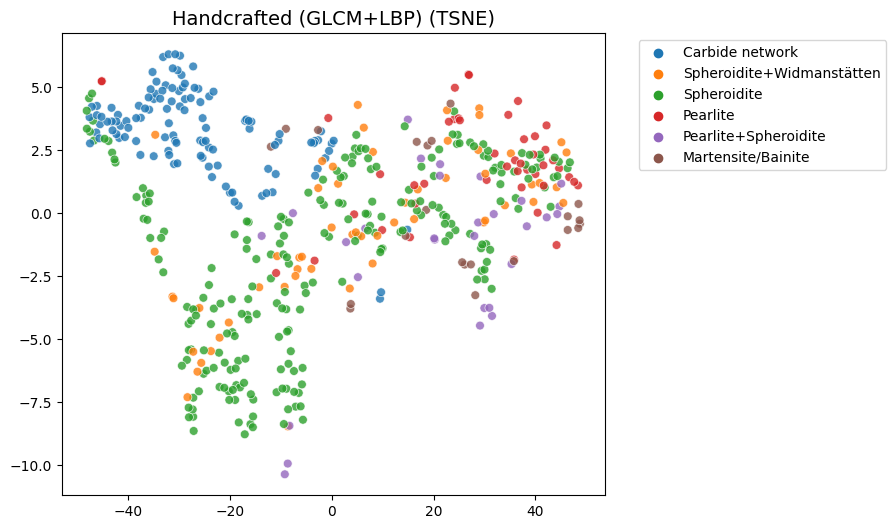

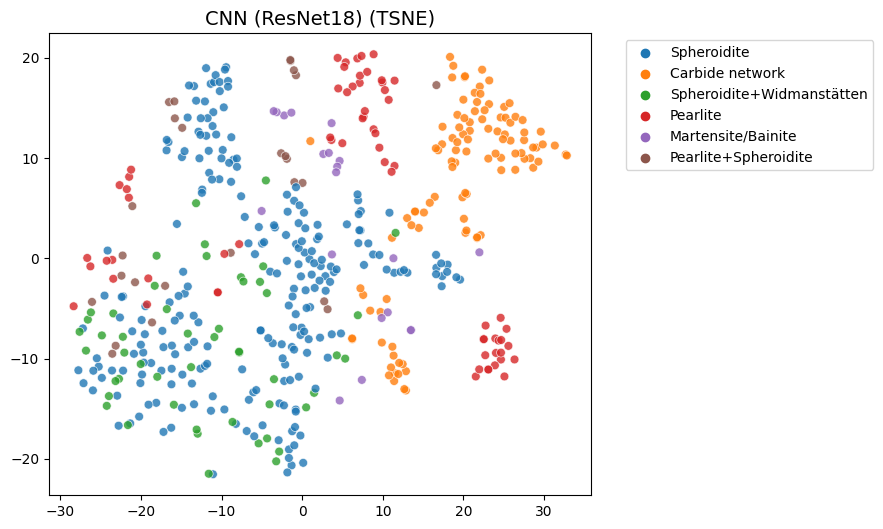

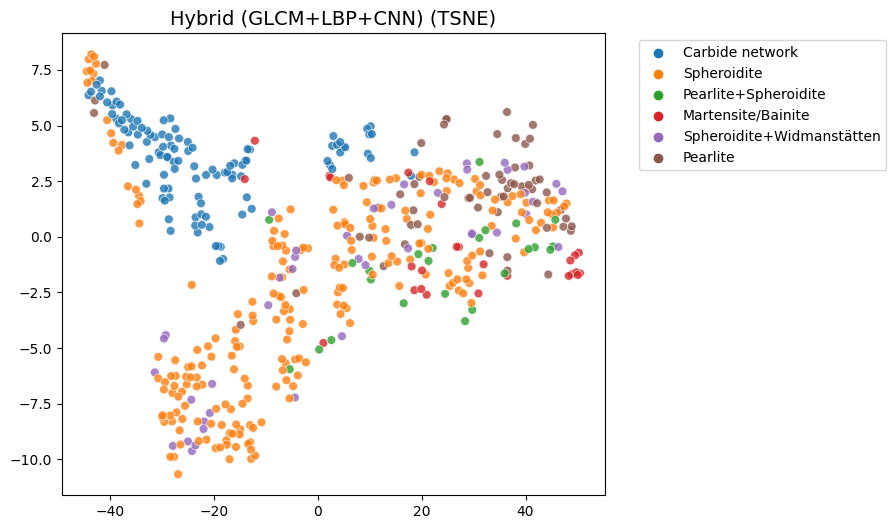

/Users/justin/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


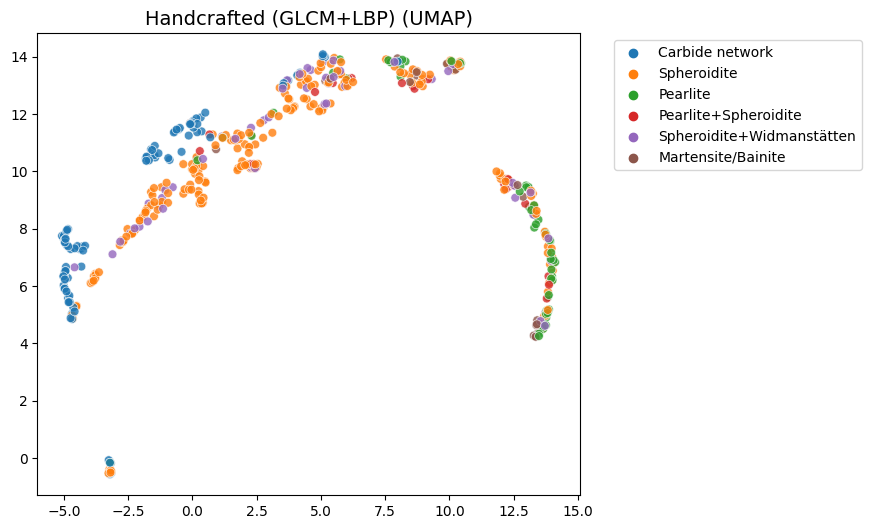

/Users/justin/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


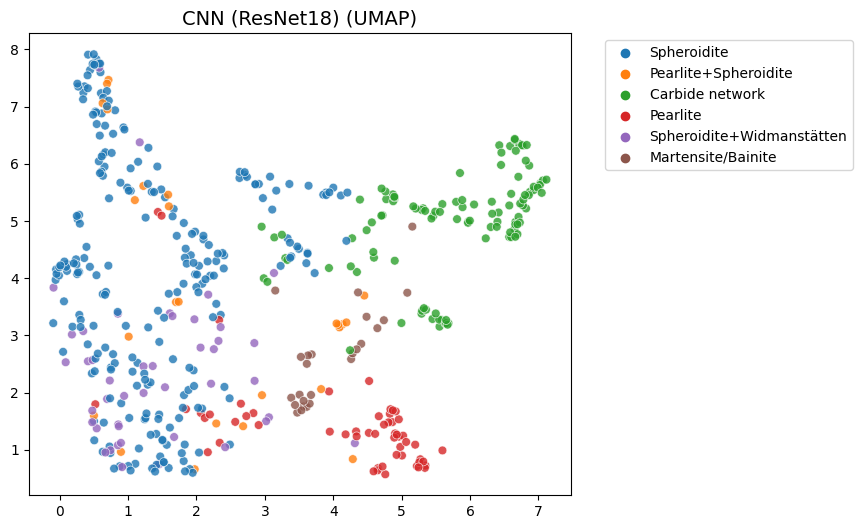

/Users/justin/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


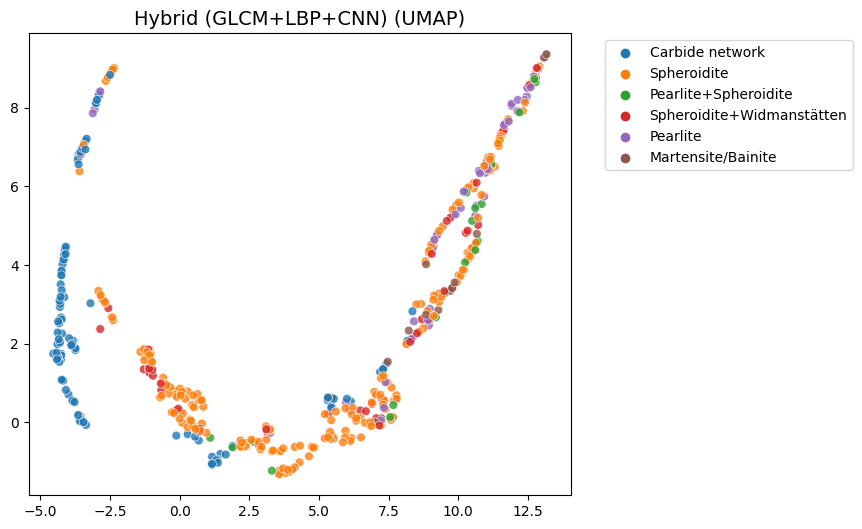

In [93]:
# Cell 16 — 2D visualization of handcrafted vs CNN vs Hybrid features

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
import seaborn as sns

# Combine train + test so we can see full dataset
def concat_features(Xtr, Xte, y_tr, y_te):
    X = np.vstack([Xtr, Xte])
    y = np.concatenate([y_tr, y_te])
    return X, y

# 1. Handcrafted (GLCM+LBP)
X_hand, y_hand = concat_features(Xtr, Xte, y_tr, y_te)

# 2. CNN
X_cnn, y_cnn = concat_features(Xtr_deep, Xte_deep, y_tr, y_te)

# 3. Hybrid
X_hyb, y_hyb = concat_features(Xtr_hybrid, Xte_hybrid, y_tr, y_te)

def plot_embedding(X, y, title, method="tsne"):
    # Subsample if too many points
    n = min(len(y), 500)
    idx = np.random.choice(len(y), n, replace=False)
    Xs, ys = X[idx], y[idx]

    if method == "tsne":
        emb = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(Xs)
    else:
        reducer = umap.UMAP(n_components=2, random_state=42)
        emb = reducer.fit_transform(Xs)

    plt.figure(figsize=(7,6))
    sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=ys, palette="tab10", s=40, alpha=0.8)
    plt.title(f"{title} ({method.upper()})", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()

# Plot all three with both methods
plot_embedding(X_hand, y_hand, "Handcrafted (GLCM+LBP)", method="tsne")
plot_embedding(X_cnn,  y_cnn,  "CNN (ResNet18)", method="tsne")
plot_embedding(X_hyb,  y_hyb,  "Hybrid (GLCM+LBP+CNN)", method="tsne")

plot_embedding(X_hand, y_hand, "Handcrafted (GLCM+LBP)", method="umap")
plot_embedding(X_cnn,  y_cnn,  "CNN (ResNet18)", method="umap")
plot_embedding(X_hyb,  y_hyb,  "Hybrid (GLCM+LBP+CNN)", method="umap")
